# Unsupervised Shallow Machine Learning Models: CATBoost Regression

<div class="alert alert-info" role="alert" 
     style="font-size: 1.1em; padding: 10px; margin: 10px 0; text-align: center;">
    
    CATBoost: gradient boosting ensemble method that builds decision trees sequentially using ordered boosting and 
    built-in **categorical feature handling** to capture complex nonlinear relationships.
<div>

### Import Libraries including `sklearn`, `shap`, and `catboost`

In [1]:
# Data Wrangling
import glob
import pandas as pd
import numpy as np

# Machine Learn
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
import shap

# Statistical Test
import pymannkendall as mk

# Data Plotting
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

#ignorewarnings
import warnings
warnings.filterwarnings("ignore")

<div class="alert alert-info" role="alert" 
     style="font-size: 1.8em; font-weight: bold; padding: 15px; margin: 10px 0; text-align: center; background-color: #d9edf7; border-color: #bce8f1; color: #31708f; border-radius: 8px;">
    Data Preprocessing
</div>

### Load CSV files containing variables -- `glob` and pandas' `read_csv function`

In [2]:
# Define the file pattern to match relevant CSV files
file_pattern = "cmems_training/cmems_mod_glo_phy_my_0.083deg_P1D-m_*.csv"

# Read all matching CSV files into a dictionary
df_dict = {}
for file in glob.glob(file_pattern):
    var_name = file.split("_")[-1].split(".")[0]  # Extract variable name from filename
    df_dict[var_name] = pd.read_csv(file, comment='#')

# Ensure SSH is processed correctly (Dates + renaming 'zos' to 'SSH')
SSH = df_dict.get("SSH")
if SSH is not None:
    SSH['Dates'] = pd.to_datetime(SSH['time'], format='%Y-%m-%dT%H:%M:%S.%fZ', utc=True)
    SSH['Dates'] = SSH['Dates'].dt.strftime('%Y-%m-%d %H:%M')
    SSH['Dates'] = pd.to_datetime(SSH['Dates'])
    # Extract months+ years (integers)
    SSH['Month'] = SSH['Dates'].dt.month
    SSH['Year']  = SSH['Dates'].dt.year
    # Tidy up
    SSH = SSH.drop(columns=['time'])
    SSH = SSH.rename(columns={'zos': 'SSH'})    # Rename 'zos' to 'SSH'
    SSH = SSH[['Dates', 'Month', 'Year', 'SSH']]  # Keep selected vars

# Mapping of expected variables to their corresponding column names in CSVs
data_vars = {
    "SST": "thetao",
    "SSS": "so",
    "Vuo": "uo",
    "Vvo": "vo",
    "MLD": "mlotst"}

# Merge all datasets dynamically
df = SSH.copy() if SSH is not None else pd.DataFrame()

for key, col in data_vars.items():
    dataset_key = "VEL" if key in ["Vuo", "Vvo"] else key  # Ensure velocity data is accessed correctly
    if dataset_key in df_dict:
        df[key] = df_dict[dataset_key][col].values  # Assign values from each dataset

# Print the first few rows to verify the result
print(df.head())

       Dates  Month  Year       SSH        SST        SSS       Vuo       Vvo  \
0 1993-01-01      1  1993 -0.096133  25.840723  36.259041 -0.104373  0.850246   
1 1993-01-02      1  1993 -0.106815  25.672995  36.251411 -0.169683  0.775780   
2 1993-01-03      1  1993 -0.137028  25.314096  36.233101 -0.120243  0.763573   
3 1993-01-04      1  1993 -0.170598  25.159552  36.242256  0.032960  0.979034   
4 1993-01-05      1  1993 -0.165105  25.166143  36.240730  0.083010  1.031526   

         MLD  
0  66.225166  
1  69.124428  
2  63.325909  
3  50.813320  
4  49.897766  


<div class="alert alert-info" role="alert" 
     style="font-size: 1.2em; font-weight: bold; padding: 15px; margin: 10px 0; text-align: center; background-color: #d9edf7; border-color: #bce8f1; color: #31708f; border-radius: 8px;">

    We can now also include SEASON as an additional category. 
<div>

In [3]:
# Create Categorical Variable: Season
def get_season(month):
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    else:
        return "Autumn"

# Apply the function to create a new column 'Season'
df['Season'] = df['Month'].apply(get_season)
# Print the first few rows to verify the result
print(df.head())

       Dates  Month  Year       SSH        SST        SSS       Vuo       Vvo  \
0 1993-01-01      1  1993 -0.096133  25.840723  36.259041 -0.104373  0.850246   
1 1993-01-02      1  1993 -0.106815  25.672995  36.251411 -0.169683  0.775780   
2 1993-01-03      1  1993 -0.137028  25.314096  36.233101 -0.120243  0.763573   
3 1993-01-04      1  1993 -0.170598  25.159552  36.242256  0.032960  0.979034   
4 1993-01-05      1  1993 -0.165105  25.166143  36.240730  0.083010  1.031526   

         MLD  Season  
0  66.225166  Winter  
1  69.124428  Winter  
2  63.325909  Winter  
3  50.813320  Winter  
4  49.897766  Winter  


### Set the `predictor` and `target` variables (X, y)

In [4]:
predictors = ['Month', 'Year', 'Season', 'SSH', 'SSS', 'Vuo', 'Vvo', 'MLD'] # Predictor vars
X = df[predictors]        # Use without (.values) so "Season" stays categorical.
y = df['SST'].values      # Target variable SST keeps (.values)
# Needs to be (n,n)(n,)
print(X.shape, y.shape)

(10408, 8) (10408,)


### Split the data into two sets: `training` (80%) and `test` (20%)

In [5]:
# Split your dataset so 20% is set aside for testing (0.2) 
# Set random_state to ensure yr train-test split is always the same (for reproducibility)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the 80% training: 20% testing split
print("Trainin set size:", X_train.shape[0])
print("Testing set size:",  X_test.shape[0])

Trainin set size: 8326
Testing set size: 2082


<div class="alert alert-info" role="alert" 
     style="font-size: 1.8em; font-weight: bold; padding: 15px; margin: 10px 0; text-align: center; background-color: #d9edf7; border-color: #bce8f1; color: #31708f; border-radius: 8px;">
    
    CatBoost Regressor
<div>

In [6]:
# Initialise and Train the model
cat_model = CatBoostRegressor(iterations = 100,        # Number of boosting iterations
                              learning_rate = 0.1,     # Step size shrinkage
                              depth = 5,               # Maximum tree depth
                              verbose = 0,             # Suppress training output
                              random_state = 42)

In [7]:
# Train the model, specifying that 'Season': categorical
cat_model.fit(X_train, y_train, cat_features=['Season'])

# Predict SST on the test dataset
y_pred = cat_model.predict(X_test)

<div class="alert alert-info" role="alert" 
     style="font-size: 1.8em; font-weight: bold; padding: 15px; margin: 10px 0; text-align: center; background-color: #d9edf7; border-color: #bce8f1; color: #31708f; border-radius: 8px;">
    Evaluating Model Performance
</div>

### Metrics for CatBoost Model: `R2` and `RMSE`

In [8]:
# Evaluate Cat Model Performance - RMSE, R² score
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# Print output to 2 decimal places:
print(f"CatBoost R²  : {r2:.2f}")
print(f"CatBoost RMSE: {rmse:.2f}")

CatBoost R²  : 0.94
CatBoost RMSE: 0.47


### Really close! Let's see if we can improve on this like with did with XGBoost -- hyperparameters

<div class="alert alert-info" role="alert" 
     style="font-size: 1.5em; padding: 15px; margin: 10px 0; text-align: center; background-color: #d9edf7; border-color: #bce8f1; color: #31708f; border-radius: 8px;">
    
    Hyperparameter Tuning
<div>

In [9]:
# Define a parameter grid for CatBoost.
# Each key corresponds to a hyperparameter, and the associated list contains the values that will be randomly sampled.
param_dist = {
    'iterations': [100, 200, 300],         # Number of boosting iterations (trees) to build.
    'learning_rate': [0.01, 0.05, 0.1],    # Learning rate: the step size for updating the model. # Lower values typically require more iterations and can lead to better generalization.
    'depth': [4, 5, 6, 7],                 # Maximum depth of each tree; deeper trees can capture more complex patterns but may overfit.
    'l2_leaf_reg': [1, 3, 5, 7]            # L2 regularization coefficient for leaf values; higher values help reduce overfitting.
}

# Initialize the CatBoostRegressor model.
# Set the loss_function to 'RMSE' (Root Mean Squared Error)
cat_model = CatBoostRegressor(loss_function = 'RMSE', verbose = 0, random_state = 42) # verbose = 0 to suppress training output


# Setup RandomizedSearchCV for hyperparameter tuning:
# - estimator: the base model to optimize (our CatBoostRegressor).
# - param_distributions: the hyperparameter grid defined above.
# - n_iter: the number of random combinations to try (here, 100 different sets).
# - scoring: the performance metric to evaluate (R² in this case).
# - cv: the number of cross-validation folds (5-fold CV).
# - verbose: prints progress messages during the search.
# - n_jobs: uses all available CPU cores (-1) to speed up the process.
# - random_state: ensures reproducibility of the random search.
random_search = RandomizedSearchCV(
    estimator = cat_model,                
    param_distributions = param_dist,     
    n_iter = 100,                         
    scoring = 'r2',                      
    cv = 5,                               # 5-fold cross-validation.
    verbose = 1,                          # Print progress messages.
    n_jobs = -1,                          # Use all available cores.
    random_state = 42)

# Fit on training data specifying that 'Season': categorical
random_search.fit(X_train, y_train, cat_features=['Season'])

# Print best hyperparameters and cross-validation (CV) scores
print("Best parameters:", random_search.best_params_)
print("Best CV R²: {:.2f}".format(random_search.best_score_))

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters: {'learning_rate': 0.1, 'l2_leaf_reg': 3, 'iterations': 300, 'depth': 7}
Best CV R²: 0.96


In [10]:
# Save the model to a JSON file
random_search.best_estimator_.save_model("cat_sst_model0.json")

In [11]:
# Using SHAP to explain our model predictions with XGBoost
explainer = shap.TreeExplainer(random_search.best_estimator_)  # Use best_estimator_ from random_search
shap_vals = explainer.shap_values(X_test)                      # Compute SHAP values for your test data

# Compute the mean absolute SHAP values for each feature
# This provides a robust measure of feature importance
shap_importance = np.abs(shap_vals).mean(axis = 0)

# Create df of the features and their importance (SHAP)
shap_df = pd.DataFrame({
    "Variable": predictors,
    "Mean Absolute SHAP": shap_importance})

# Sort shap_df so the most important features (variables) are at the top:
shap_df.sort_values(by = "Mean Absolute SHAP", ascending = False, inplace = True)
print(shap_df)

  Variable  Mean Absolute SHAP
0    Month            1.159226
3      SSH            0.511597
7      MLD            0.370236
1     Year            0.117993
4      SSS            0.106779
6      Vvo            0.103494
2   Season            0.051504
5      Vuo            0.016063


### `Month` is still the most important feature. `Season` does contribute, but it's not made a big improvement to `R²`.

<div class="alert alert-info" role="alert" 
     style="font-size: 1.6em; font-weight: bold; padding: 10px; margin: 10px 0; text-align: center;">

    CatBoost model deployment

<div>

### Load new files -- `glob` and pandas' `read_csv function`

In [12]:
# Define the file pattern to match the new CSV files
file_pattern = "cmems_testing_/cmems_mod_glo_phy-*_0.083deg_P1D-m.csv"

# Read all matching CSV files into a dictionary
df_dict = {}
for file in glob.glob(file_pattern):
    # Extract variable name: get text after 'cmems_mod_glo_phy-' and before the first underscore
    var_name = file.split("cmems_mod_glo_phy-")[-1].split("_")[0]
    df_dict[var_name.upper()] = pd.read_csv(file, comment='#')  # Use upper-case keys for consistency

# Process SSH separately (for Dates and renaming 'zos' to 'SSH')
# Assuming the SSH file is named like: cmems_mod_glo_phy-ssh_0.083deg_P1D-m.csv
SSH = df_dict.get("SSH")
if SSH is not None:
    SSH['Dates'] = pd.to_datetime(SSH['time'], format='%Y-%m-%dT%H:%M:%S.%fZ', utc=True)
    SSH['Dates'] = SSH['Dates'].dt.strftime('%Y-%m-%d %H:%M')
    SSH['Dates'] = pd.to_datetime(SSH['Dates'])
    # Extract months+ years (integers)
    SSH['Month'] = SSH['Dates'].dt.month
    SSH['Year']  = SSH['Dates'].dt.year
    # Tidy up
    SSH = SSH.drop(columns=['time'])
    SSH = SSH.rename(columns={'zos': 'SSH'})    # Rename 'zos' to 'SSH'
    SSH = SSH[['Dates', 'Month', 'Year', 'SSH']]  # Keep selected vars

# Mapping of expected variables to their corresponding column names in CSVs.
# Use upper-case keys to match our dictionary keys.
data_vars = {
    "SST": "thetao",
    "SSS": "so",
    "Vuo": "uo",
    "Vvo": "vo",
    "MLD": "mlotst"}

# Start with the SSH DataFrame if available; otherwise, create an empty one.
new_df = SSH.copy() if SSH is not None else pd.DataFrame()

# Loop through each expected variable, and add its values if available
for key, col in data_vars.items():
    # For velocities, assume the file is named with 'VEL' instead of the variable name
    dataset_key = "VEL" if key in ["Vuo", "Vvo"] else key
    # Here, we assume that in the new files the key is simply the variable name (upper-case)
    if dataset_key in df_dict:
        new_df[key] = df_dict[dataset_key][col].values  # Assign the column values

# Print the first few rows to verify the result
print(new_df.head(2))

       Dates  Month  Year      SSH        SST        SSS       Vuo       Vvo  \
0 2022-06-01      6  2022 -0.15710  28.285259  36.208824  0.214361  2.172305   
1 2022-06-02      6  2022 -0.15786  28.619026  36.249100  0.250755  2.062931   

         MLD  
0  11.826362  
1  15.236107  


In [13]:
# Create Categorical Variable: Season
def get_season(month):
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    else:
        return "Autumn"

# Apply the function to create a new column 'Season'
new_df['Season'] = new_df['Month'].apply(get_season)
# Print the first few rows to verify the result
print(new_df.head(2))

       Dates  Month  Year      SSH        SST        SSS       Vuo       Vvo  \
0 2022-06-01      6  2022 -0.15710  28.285259  36.208824  0.214361  2.172305   
1 2022-06-02      6  2022 -0.15786  28.619026  36.249100  0.250755  2.062931   

         MLD  Season  
0  11.826362  Summer  
1  15.236107  Summer  


In [14]:
predictors = ['Month', 'Year', 'Season', 'SSH', 'SSS', 'Vuo', 'Vvo', 'MLD'] # Predictor vars
X_new = new_df[predictors]        # Use without (.values) so "Season" stays categorical.
y_new = new_df['SST'].values      # Target variable SST keeps (.values)
# Needs to be (n,n)(n,)
print(X_new.shape, y_new.shape)

(1028, 8) (1028,)


<div class="alert alert-info" role="alert" 
     style="font-size: 1.5em; padding: 15px; margin: 10px 0; text-align: center; background-color: #d9edf7; border-color: #bce8f1; color: #31708f; border-radius: 8px;">
    
    Fit Trained CatBoost Regressor
<div>

In [15]:
sst_model = CatBoostRegressor()      
sst_model.load_model("cat_sst_model0.json");  # Load the model saved to disk

In [16]:
# Saved XGBoost model: predict 'new' SST
sst_pred = sst_model.predict(X_new)

# Evaluate model performance on new data:
new_r2 = r2_score(y_new, sst_pred)
new_rmse = np.sqrt(mean_squared_error(y_new, sst_pred))

print("New Cat R²:   {:.2f}".format(new_r2))
print("New Cat RMSE: {:.2f}".format(new_rmse))

New Cat R²:   0.80
New Cat RMSE: 0.98


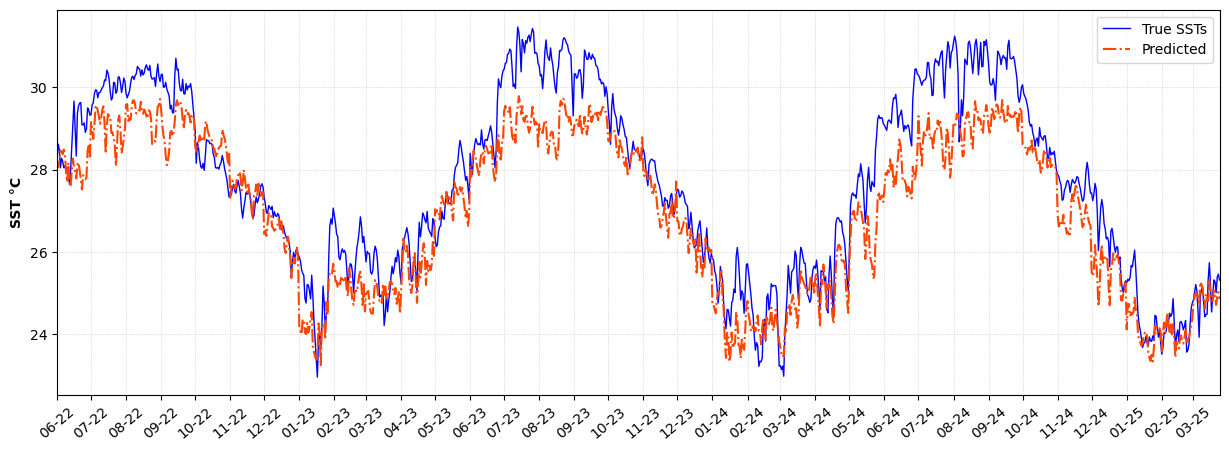

In [17]:
# Create figure
fig1, ax = plt.subplots(1, 1, figsize=(15, 5))

# Plot True and Predicted SSTs
ax.plot(new_df['Dates'], new_df['SST'], linestyle = '-', c = 'blue', linewidth = 1.0, label = 'True SSTs')
ax.plot(new_df['Dates'], sst_pred,linestyle = '-.', c = 'orangered', linewidth = 1.5, label = 'Predicted')

# Formatting
ax.grid(True, color = 'silver', linestyle = ':', linewidth = 0.5)
ax.set_xlim([np.nanmin(new_df['Dates']), np.nanmax(new_df['Dates'])])
ax.set_ylabel('SST °C', fontsize = 10, weight = 'bold')
ax.legend();

# Set the x-axis major locator to every 3 months
ax.xaxis.set_major_locator(mdates.MonthLocator(interval = 1))
# Format the x-axis ticks as 'mm-yy'
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%y'))
# Rotate tick labels for better readability
plt.setp(ax.get_xticklabels(), rotation = 40, ha = 'center')

plt.show()

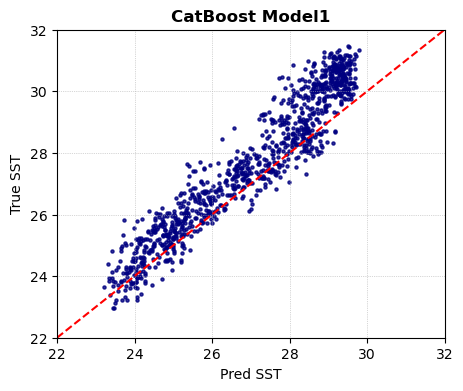

In [18]:
# Create Scatterplot
fig2, ax = plt.subplots(1, 1, figsize=(5, 4))
# Plot True and Predicted SSTs
ax.scatter(sst_pred, new_df['SST'], color = 'navy', alpha = 0.8, marker = 'o', s = 5)
# Set axes limits
ax.set_xlim(22, 32)
ax.set_ylim(22, 32)
# Plot a 1:1 line
ax.plot([22, 32], [22, 32], color = 'red', linestyle = '--', linewidth = 1.5)
# Formatting 
ax.set_xlabel('Pred SST')                           
ax.set_ylabel('True SST')                           
ax.set_title('CatBoost Model1',weight = 'bold')    
ax.grid(True, linestyle = ':', linewidth = 0.5) 

In [20]:
fig2.savefig('CatBoost1_Scatterp.png', bbox_inches='tight')